In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import re
from simplemma import text_lemmatizer
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("urun-yorumlari.csv", sep=";")
df.head(-5)

,Metin,Durum
0,evet anlatıldığı gibi,1
1,Daha öncede almıştım bu cihazdan ense ve sakal...,1
2,Ürün gayet başarılı sakal kesmede başlık sayıs...,1
3,Daha öncede aynısını almıştım çok güzel ve kal...,1
4,Erkek kuaförüyüm ense ve sıfır sakal traşı içi...,1
...,...,...
9767,Şahane?? bağımlı olmamak elde değil ??,1
9768,Harika gerçekn bayıkdım,1
9769,Çok bisey bekleyin eğlenceli zevkli minim atar...,1
9770,Bu ürün hem kaliteli hem de kullanışlı,1


In [3]:
stop_words = None
with open("stopwords.txt", "r") as stop_file:
    stop_words = set(stop_file.read().splitlines())

def clean(text):
    text = text.replace("Â", "a")
    text = text.replace("â", "a")
    text = text.replace("î", "i")
    text = text.replace("Î", "ı")
    text = text.replace("İ", "i")
    text = text.replace("I", "ı")
    text = text.replace(u"\u00A0", " ")
    text = text.replace("|", " ")

    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    text = re.sub(r"(.)\1+", r"\1\1", text)
    text = re.sub(r"https?:\/\/\S+", " ", text)
    text = re.sub(r"http?:\/\/\S+", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"#(\w+)", " ", text)
    text = re.sub(r"^\x00-\x7F]+", " ", text)
    text = re.sub(r"[^A-Za-zâîığüşöçİĞÜŞÖÇ]+", " ", text)
    text = re.sub(r"((https://[^\s]+))", " ", text)

    text = " ".join(text.lower().strip().split())
    text = text_lemmatizer(text, lang="tr")

    return " ".join([word for word in text if word not in stop_words])

In [4]:
df = pd.read_csv("urun-yorumlari.csv", sep=";")

df["Temiz"] = df["Metin"].apply(lambda row: clean(row))
df.dropna(subset=["Temiz"], inplace=True)

df.to_csv("son-yorum.csv", index=False)

df.head(-5)

,Metin,Durum,Temiz
0,evet anlatıldığı gibi,1,evet anlat
1,Daha öncede almıştım bu cihazdan ense ve sakal...,1,önce al cihaz ense sakal tüket için numara sıf...
2,Ürün gayet başarılı sakal kesmede başlık sayıs...,1,ürün gayet başarı sakal kes başlık sayı fazla ...
3,Daha öncede aynısını almıştım çok güzel ve kal...,1,önce aynı al çok güzel kalite ürün
4,Erkek kuaförüyüm ense ve sıfır sakal traşı içi...,1,erkek kuaför ense sıfır sakal traşı için uygun...
...,...,...,...
9767,Şahane?? bağımlı olmamak elde değil ??,1,şahane bağımlı el değil
9768,Harika gerçekn bayıkdım,1,harika gerçekn bayıkdım
9769,Çok bisey bekleyin eğlenceli zevkli minim atar...,1,çok bisey bekle eğlence zevk mini atarı
9770,Bu ürün hem kaliteli hem de kullanışlı,1,ürün kalite kullan


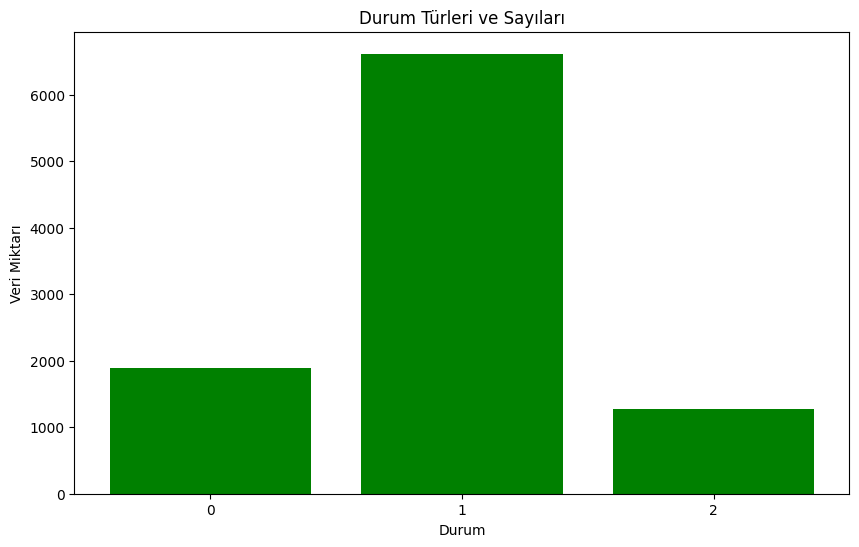

In [5]:
# Veri setinden durum ve sayılarını al
durum_turleri = df["Durum"].value_counts()

# Grafik boyutunu ayarlama
fig, ax = plt.subplots(figsize=(10, 6))

# Grafik çizimi
ax.bar(durum_turleri.index, durum_turleri, color="green")

# x ekseninde durumları düzgün bir şekilde gösterme
plt.xticks(durum_turleri.index)

plt.title("Durum Türleri ve Sayıları")
plt.xlabel("Durum")
plt.ylabel("Veri Miktarı")
plt.show()

In [6]:
# model eğitimi
df = pd.read_csv("son-yorum.csv")

X = df["Temiz"].astype(str).to_numpy()
y = df["Durum"].to_numpy()

print(len(X), len(y))

9777 9777


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# vektörleştirme
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [9]:
# Decision Tree ile 
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1)
clf.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(max_depth=5)

In [10]:
# model başarısı 
clf.score(X_test_tfidf, y_test)

0.7464212678936605

In [11]:
# dışarıdan girilen girdi için marka tahmini
yeni_metin = "Makine efsane Almayı Kaçırmayın ben çok Beğendim"
yeni_metin_tfidf = vectorizer.transform([yeni_metin])
yeni_metin_tfidf = vectorizer.transform([yeni_metin])
tahmin_indeks = clf.predict(yeni_metin_tfidf.toarray())[0]
print(tahmin_indeks)

1
